<a href="https://colab.research.google.com/github/OmdenaAI/KenyaRedCross/blob/main/Damage%20Assessment/Damage_Assessment_Sentinel_2_Images_'Naive_Approach'.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Damage Assessment
The first part is a Detailed exploration of the top 10 before and after sentinel-2 images with the greatest change in NDVI index. The following steps were used:
1. Loading the pair of images from Google Drive(*before* and *after*).
2. Calculating the NDVI difference and finding the maximum NDVI difference.
3. Categorizing the images by location(County).
4. Identifying the Counties which the top ten pair of images with the highest NDVI difference belong to.

The second part uses a 'naive approach' to assess the damage done on vegetation by the Desert Locust based on the set Sentinel 2 images(before and after).  The following steps are used to do the analysis:
1. Loading the pair images from Google Drive.
2. Calculating the NDVI difference between the the before and after image.
3. Categorizing each image by County.
4. Using the NDVI difference to calculate the number of pixels where a negative change in vegetation(NDVI difference >0) was observed. This gives the number of affected pixels.
5. Getting the total area per image by multiplying affected_pixels * 10m * 10m and converting to hectares.
6. Grouping the dataframe by County and aggretting the images.(Summing the total area affected per image).
7. Calculating the degree of damage per county by categorizing the NDVI difference into low,moderate and high damage.




In [2]:
#suppressing output of the cell
%%capture  
#installing necessary dependencies
!pip -q install geopandas
!pip -q install geojson
!pip -q install --upgrade folium
!pip -q install geemap
!pip -q install rasterio
!pip -q install geopandas geojson geemap rasterio earthpy
!pip -q install rioxarray
!pip install fastai --upgrade

In [3]:
# importing libraries
import os
import json
import requests
import glob
from pathlib import Path

import geojson
import rasterio as rio
#import rioxarray as rxr
from rasterio.plot import show
import geopandas as gpd
import ee
import geemap
import geemap.eefolium as emap
import folium
from folium import plugins
import earthpy.spatial as es
import earthpy.plot as ep
from shapely.geometry import Point, Polygon
import fastai
from rasterio.plot import show_hist


from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from scipy import stats
from functools import reduce
import gc 
import time

from  IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

**Mounting Drive**

In [4]:
from google.colab import drive
drive.mount('/content/drive',force_remount = True)

Mounted at /content/drive


### **Loading the Images**

In [5]:
#Directory for storage of sentinel 2 images
%cd '/content/drive/My Drive/Official Folder of Kenya Red Cross Desert Locust Project/Data/Sentinel_Data/dl_aoi/Kenya_AOI_224/Kenya_AOI_224_GeoTiff'


/content/drive/.shortcut-targets-by-id/12QHGizgz_g-tBWlzTcLz5dz_YOtWUXz8/Official Folder of Kenya Red Cross Desert Locust Project/Data/Sentinel_Data/dl_aoi/Kenya_AOI_224/Kenya_AOI_224_GeoTiff


In [6]:
#path to before sentinel images
#paths for the .tif images
data_path = 'Kenya_AOI_before_224_clean'
bf_data = Path(data_path)

#the tif images are stored in the paths list
bf_data = glob.glob(os.path.join(bf_data,'*.tif'))
bf_data[:5]

['Kenya_AOI_before_224_clean/kenya_aoi_before (1).tif',
 'Kenya_AOI_before_224_clean/kenya_aoi_before (55).tif',
 'Kenya_AOI_before_224_clean/kenya_aoi_before (53).tif',
 'Kenya_AOI_before_224_clean/kenya_aoi_before (52).tif',
 'Kenya_AOI_before_224_clean/kenya_aoi_before (51).tif']

In [7]:
#path to after sentiel images
#paths for the .tif images
data_path = 'Kenya_AOI_after_224_clean'
af_data = Path(data_path)

#the tif images are stored in the paths list
af_data = glob.glob(os.path.join(af_data,'*.tif'))
af_data[:5]

['Kenya_AOI_after_224_clean/kenya_aoi_after (9).tif',
 'Kenya_AOI_after_224_clean/kenya_aoi_after (1).tif',
 'Kenya_AOI_after_224_clean/kenya_aoi_after (2).tif',
 'Kenya_AOI_after_224_clean/kenya_aoi_after (3).tif',
 'Kenya_AOI_after_224_clean/kenya_aoi_after (4).tif']

In [ ]:
print("Length of bf data=", len(bf_data))
print("Length of af data=", len(af_data))

Length of bf data= 348
Length of af data= 348


In [ ]:
#Extracting image_ID
int(bf_data[0].split('(')[1].split(')')[0])

1

In [8]:
#using for loop and storing the items into a dictionary
folder = {}
bf_list = bf_data.copy()
af_list = af_data.copy()
#iterating through the images
for i in range(len(bf_data)):
  files = []  #holds the before and after images
  for  j in range(len(af_data)):
    #checking for equality, splitting by the first parantheses in the string
    if str(bf_data[i].split('(')[1]) == str(af_data[j].split('(')[1]):
      #extracting the image_Id from the image name
      key = bf_data[i].split('(')[1].split(')')[0]
      files = [bf_data[i],af_data[j]]
      folder[key] = files
      bf_list.remove(bf_data[i]) #removing the matcged image 
      af_list.remove(af_data[j])

print('The number of correctly matched images: ',len(folder.keys()))
print("The number of mismatched images are: ",len(bf_list))

The number of correctly matched images:  348
The number of mismatched images are:  0


In [ ]:
#checking the mismatched images
bf_list

[]

In [ ]:
af_list

[]

### Comparing NDVI for image Pairs

In [ ]:
#comparing the NDVI for the first image
bf = rio.open(folder[0][0])
af = rio.open(folder[0][1])

In [ ]:
#checking the descriptions of the images
bf.descriptions

(None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None)

In [ ]:
# reading the NDVI band from the image
bf_ndvi = bf.read(17)
af_ndvi = af.read(17)


In [ ]:
#getting the min and max ndvi for before image
bf_ndvi.min(), bf_ndvi.max()

(0.17267314, 0.82824653)

In [9]:
#Parameters
numMismatch = [] #holding the folder_Ids for mismateched images

#Creating a dataframe for storing the ndvi values
ndvi_diff_df = pd.DataFrame(columns = ["Image_ID","bf_ndvi", "af_ndvi", 'diff_ndvi', "ndvi_diff_max"])

#iterating through all the images in the folder
for key in folder:
  #loading image from tif file using rasterio
  bf = rio.open(folder[key][0])
  af = rio.open(folder[key][1])

  # reading the NDVI band from the image
  bf_ndvi = bf.read(17)
  af_ndvi = af.read(17)

  #checking for mismatch 
  if (bf_ndvi.shape!=af_ndvi.shape):
      #print("Mismatch found!bf_nvdi shape = ",bf_ndvi.shape, ", af_nvdi shape = ",af_ndvi.shape)
      numMismatch.append(key)
      continue
  else :
    #calculating the NDVI difference
    diff_ndvi = bf_ndvi - af_ndvi

    #Saving the maximum NDVI difference 
    ndvi_diff_df = ndvi_diff_df.append({'Image_ID':key,'bf_ndvi':bf_ndvi, 'af_ndvi':af_ndvi,
                                        'diff_ndvi':diff_ndvi,
                                        'ndvi_diff_max':diff_ndvi.max()},ignore_index = True)

print("Number of cases where bf_ndvi shape is not equal to af_nvdi=", len(numMismatch))

Number of cases where bf_ndvi shape is not equal to af_nvdi= 0


In [10]:
#checking the dataframe
ndvi_diff_df.head()

,Image_ID,bf_ndvi,af_ndvi,diff_ndvi,ndvi_diff_max
0,1,"[[0.6540928, 0.7247365, 0.73649657, 0.68076646...","[[0.67011, 0.66323024, 0.5968, 0.5591907, 0.58...","[[-0.016017199, 0.06150627, 0.13969654, 0.1215...",0.613031
1,55,"[[0.08205321, 0.117272384, 0.1314328, 0.122627...","[[0.07734909, 0.09608798, 0.1018936, 0.0982822...","[[0.004704118, 0.021184407, 0.029539205, 0.024...",0.497875
2,53,"[[0.14920926, 0.13477975, 0.11140065, 0.119540...","[[0.14750317, 0.12361743, 0.11880144, 0.138575...","[[0.0017060935, 0.011162318, -0.0074007884, -0...",0.235844
3,52,"[[0.13408345, 0.18135959, 0.12106768, 0.122937...","[[0.15126427, 0.14806329, 0.1387508, 0.1270837...","[[-0.017180815, 0.033296302, -0.017683126, -0....",0.181141
4,51,"[[0.06656226, 0.07846343, 0.08486622, 0.070197...","[[0.053564318, 0.057248764, 0.055595227, 0.052...","[[0.01299794, 0.021214664, 0.029270992, 0.0179...",0.236209


In [ ]:
#checking to see if all the images have been  images exluding the...
#...mismatched names and unequal NDVI. 
ndvi_diff_df.shape[0]

348

In [ ]:
#checking for the maximum NDVI difference
ndvi_diff_df['ndvi_diff_max'].max()

0.8126615285873413

In [11]:
#sorting the dataframe by the NDVI values
ndvi_diff_df = ndvi_diff_df.sort_values('ndvi_diff_max',ascending=False)
ndvi_diff_df  = ndvi_diff_df .reset_index(drop=True)

ndvi_diff_df.head()

,Image_ID,bf_ndvi,af_ndvi,diff_ndvi,ndvi_diff_max
0,230,"[[-0.12935324, -0.10880195, -0.11806914, -0.12...","[[-0.1765873, -0.17228104, -0.1592233, -0.1801...","[[0.04723406, 0.06347909, 0.04115416, 0.053545...",0.812662
1,184,"[[0.7350629, 0.7675051, 0.7960644, 0.807897, 0...","[[0.52483046, 0.5435068, 0.5238934, 0.49418223...","[[0.21023244, 0.22399831, 0.27217096, 0.313714...",0.802576
2,192,"[[0.029045643, 0.05794856, 0.09174312, 0.02351...","[[-0.22297297, -0.18472652, -0.034264628, 0.08...","[[0.25201863, 0.24267508, 0.12600775, -0.06384...",0.798329
3,181,"[[0.36433873, 0.2812067, 0.228576, 0.22257261,...","[[0.25170445, 0.27830833, 0.28883117, 0.296162...","[[0.11263427, 0.0028983653, -0.06025517, -0.07...",0.695116
4,177,"[[0.54812837, 0.5444204, 0.53047526, 0.5078761...","[[0.36797678, 0.36814025, 0.34141216, 0.331956...","[[0.18015158, 0.17628017, 0.1890631, 0.1759198...",0.623799


**Visualizing the top 10 images having the highest NDVI differences**

In [ ]:
def Plot_ndvi(Folder_ID,bf_ndvi, af_ndvi, diff_ndvi, ndvi_diff_max):

  print("Image_ID: {} with Ndvi_diff_max {}".format(Folder_ID,ndvi_diff_max))
  colormap = plt.cm.RdYlGn
  fig = plt.figure(figsize=(15,5))
  ax = fig.add_subplot(1, 3, 1)
  imgplot = plt.imshow(bf_ndvi, cmap=colormap)
  imgplot.set_clim(-1, 1.0)
  ax.set_title('NDVI Before')
  plt.colorbar(orientation='horizontal')

  ax = fig.add_subplot(1, 3, 2)
  imgplot = plt.imshow(af_ndvi, cmap=colormap)
  imgplot.set_clim(-1, 1.0)
  ax.set_title('NDVI After')
  plt.colorbar(orientation='horizontal')

  ax = fig.add_subplot(1, 3, 3)
  imgplot = plt.imshow(diff_ndvi, cmap=plt.cm.Reds)
  imgplot.set_clim(0.0, 0.8) # 0.8 because the vegetation starts at NDVI = 0.2 -> max. damage is 0.8
  ax.set_title('NDVI Difference')
  plt.colorbar(orientation='horizontal')

  plt.show()



Image_ID: 230 with Ndvi_diff_max 0.8126615285873413


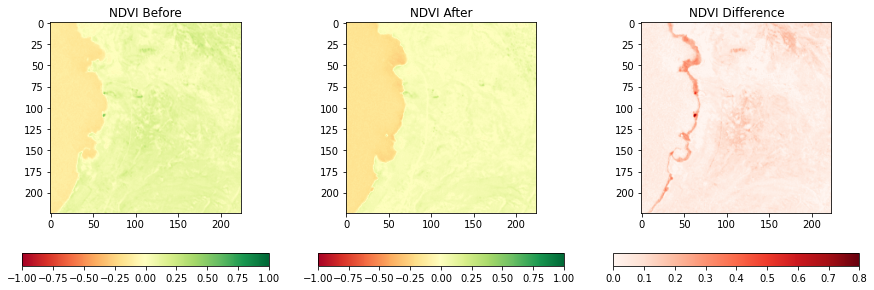

Image_ID: 184 with Ndvi_diff_max 0.8025760054588318


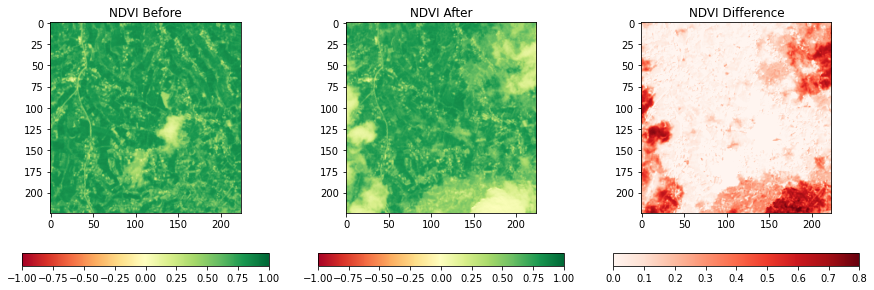

Image_ID: 192 with Ndvi_diff_max 0.7983291149139404


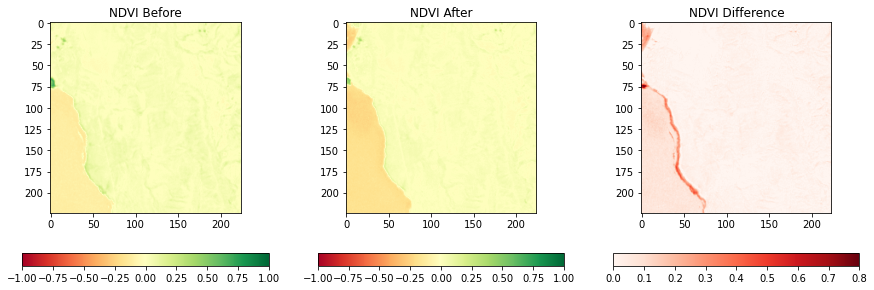

Image_ID: 181 with Ndvi_diff_max 0.6951161623001099


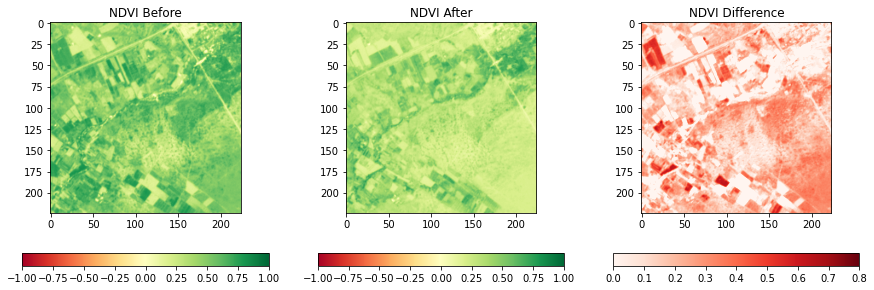

Image_ID: 177 with Ndvi_diff_max 0.6237989664077759


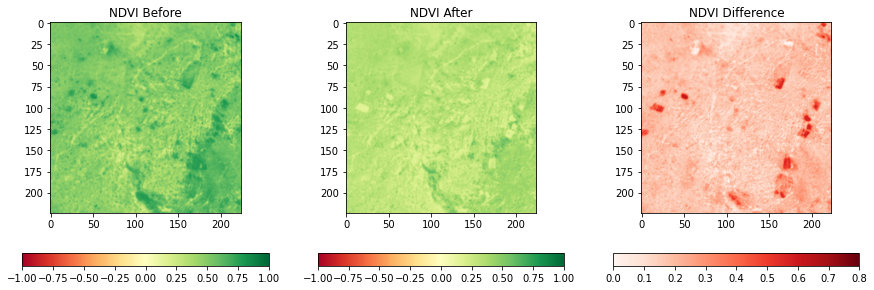

Image_ID: 1 with Ndvi_diff_max 0.6130313873291016


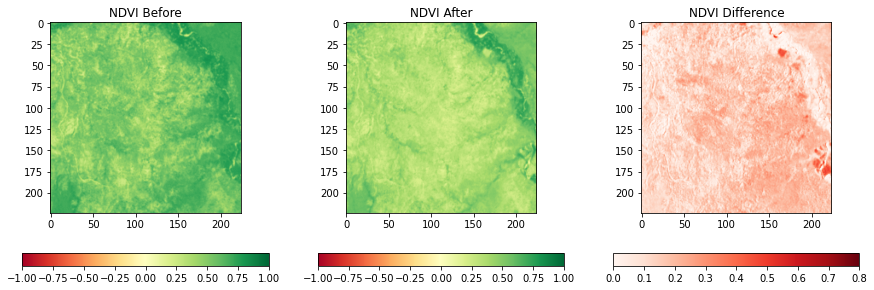

Image_ID: 178 with Ndvi_diff_max 0.6061117649078369


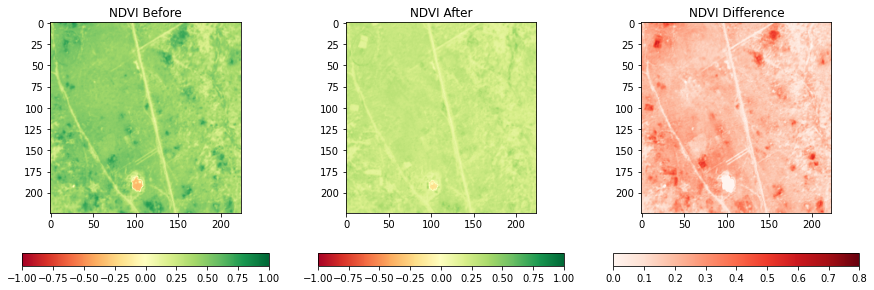

Image_ID: 219 with Ndvi_diff_max 0.6045791506767273


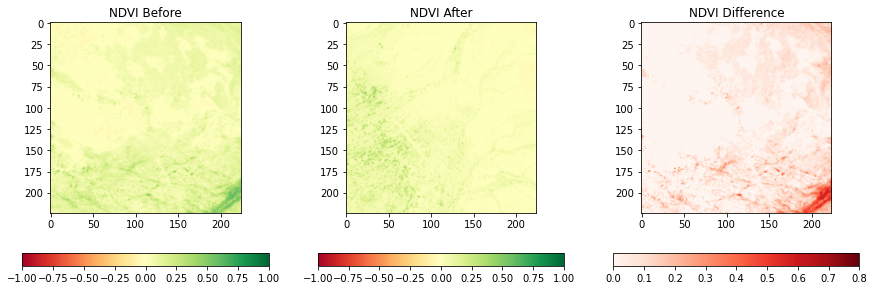

Image_ID: 176 with Ndvi_diff_max 0.5901165008544922


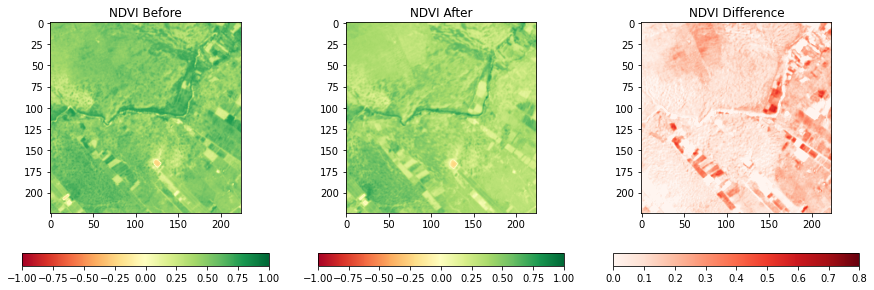

Image_ID: 166 with Ndvi_diff_max 0.5809030532836914


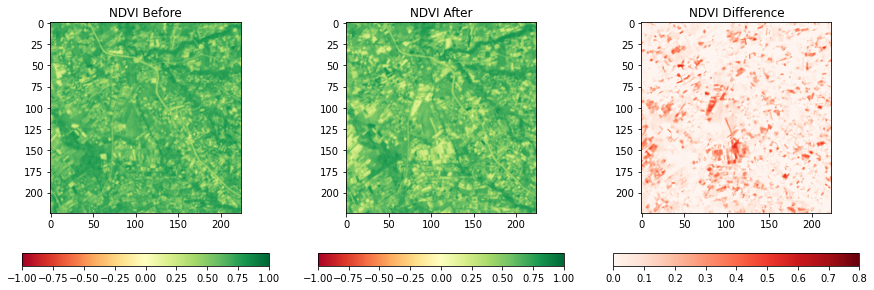

In [ ]:
#Visualizing the top ten images
for i in range(10):

  Plot_ndvi(ndvi_diff_df.iloc[i]['Image_ID'],ndvi_diff_df.iloc[i]['bf_ndvi'], ndvi_diff_df.iloc[i]['af_ndvi'], ndvi_diff_df.iloc[i]['diff_ndvi'], ndvi_diff_df.iloc[i]['ndvi_diff_max'])

**Pixel Distribution**

In [ ]:
#defining the function for plotting histograms
def Plot_Hist(Image_ID, bf_ndvi,af_ndvi):
  #Creating an array that holds both the before and after NDVI values
  Comb_ndvi = np.array([bf_ndvi,af_ndvi])
  #Visualization using EarthPy
  fig = ep.hist(
      Comb_ndvi,
      cols = 2,
      colors = ['Purple','Violet'],
      title = ['NDVI Distribution_Before_Image_ID: ' + str(Image_ID),'NDVI_Distribution_After_Image_ID: '+str(Image_ID)],
      figsize = (10,5)
  )
  plt.show()

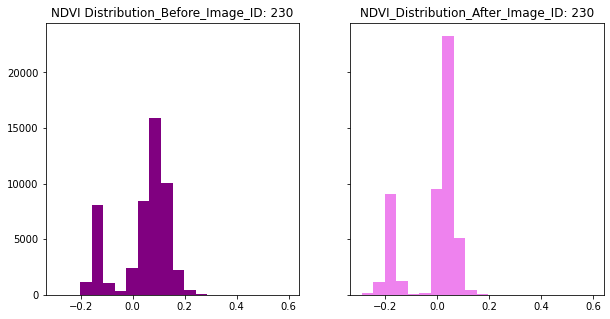

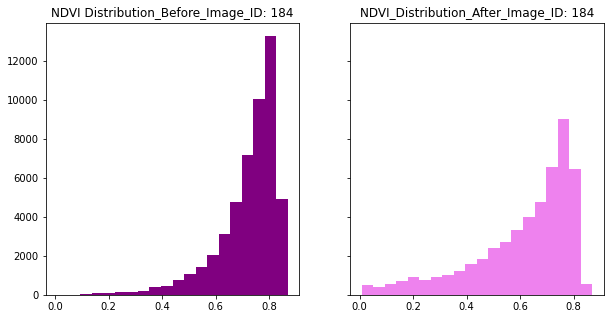

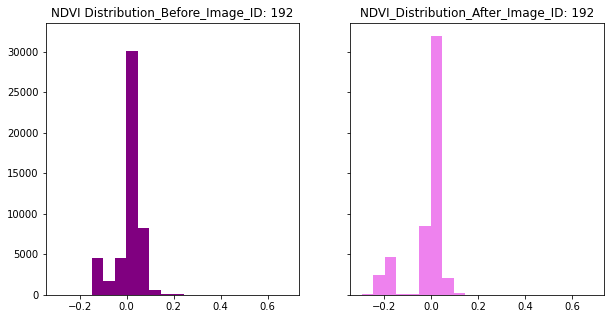

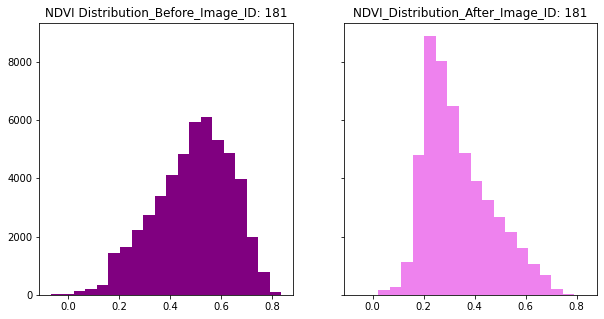

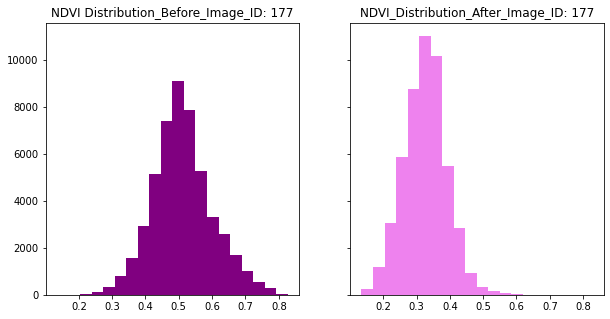

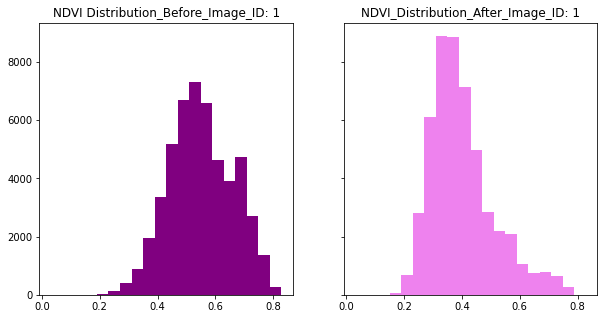

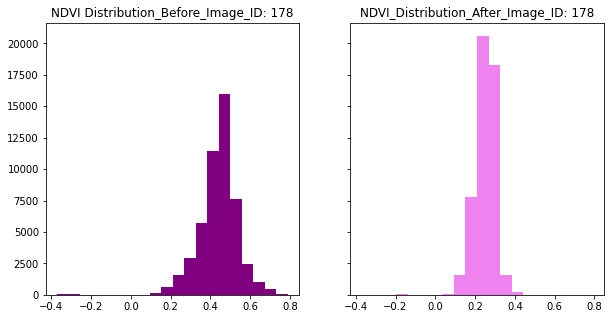

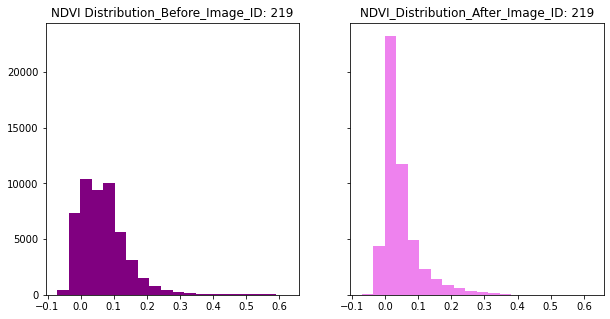

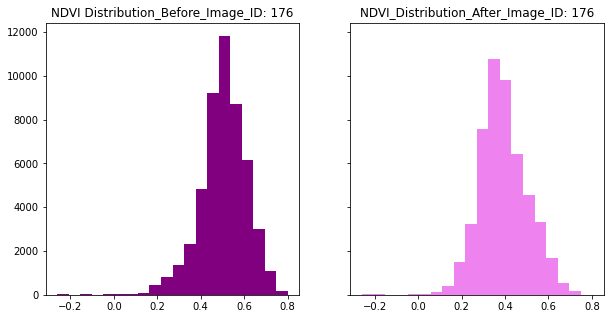

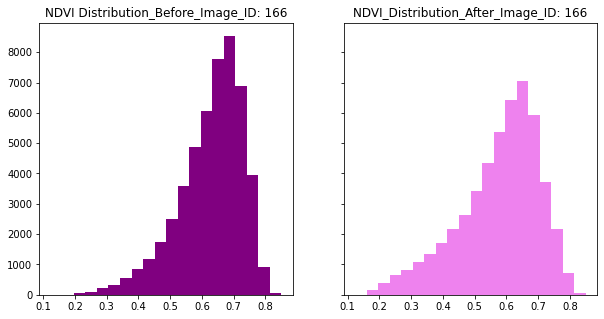

In [ ]:
#Visualizing the top ten images
for i in range(10):

  Plot_Hist(ndvi_diff_df.iloc[i]['Image_ID'],ndvi_diff_df.iloc[i]['bf_ndvi'], ndvi_diff_df.iloc[i]['af_ndvi'] )

**Identifying the Counties with the highest NDVI Difference**

In [ ]:
#The top ten images with the highest NDVI difference
top_10 = ndvi_diff_df['Image_ID'].head(10).tolist()
top_10

['230', '184', '192', '181', '177', '1', '178', '219', '176', '166']

In [ ]:
#defining a function for getting the bounds
bottom_0 = rio.open(folder[top_10[0]][0]).bounds[1]
right_1 = rio.open(folder[top_10[0]][0]).bounds[2]

In [ ]:
# function for getting the bounds for the images
m = folium.Map(location=[bottom_0,right_1],zoom_start=7)
for image in top_10:
  raster = rio.open(folder[image][0])
  bottom = raster.bounds[1]
  right = raster.bounds[2]
  folium.Marker(location=[bottom,right],popup='Default popup Marker1',tooltip='Click here to see Popup').add_to(m)

#Displaying the Map
m


The distribution of the top 10 images with the highest NDVI difference is as follows among the counties affected is as follows:
- Laikipia - 4
- Marsabit - 3
- Samburu -1 
- Kirinyaga - 1
- Nyandarua - 1

### Categorizing the Images By County

This entails categorizing each image into their respective counties. Thereafter, get the damage from the NDVI Difference. 

In [ ]:
#getting the raster bounds
image = rio.open(folder[0][0])

In [ ]:
#Getting the bounding boxes for the images.
image.bounds

BoundingBox(left=36.42012706947252, bottom=1.0200370051177166, right=36.440249331836796, top=1.040159267481994)

**Loading the Locust Hub Data**

In [ ]:
#loading the geojson file
file_path = '/content/drive/My Drive/Omdena Project/Data/hub_data.geojson'
locust_hub = gpd.read_file(file_path)
locust_hub.head()

,X,Y,OBJECTID_left,STARTDATE,TmSTARTDAT,FINISHDATE,TmFINISHDA,EXACTDATE,PARTMONTH,LOCNAME,AREAHA,LOCRELIAB,COUNTRYID,LOCUSTID,REPORTID,ACOMMENT,LOCPRESENT,SPECIESQRY,CONFIRMATN,BREEDING,REPRELIAB,SHPMINDSQM,SHPMAXDSQM,SHPMINDSIT,SHPMAXDSIT,SHPDENISOL,SHPDENSCAT,SHPDENGRP,SHPDENUNK,SHPSC,SHPSCCAT,SHPMATEGG,SHPMATHAT,SHPMATINS1,SHPMATINS2,SHPMATINS3,SHPMATINS4,SHPMATINS5,SHPMATINS6,SHPMATFLED,...,GADARVSML,GADARSML,GADARMED,GADARLGE,GADARVLGE,GADARUNK,GADFLYFROM,GADFLYTO,GADHTLOW,GADHTMED,GADHTHI,GADHTUNK,CTLSTDATE,CTLFNDATE,CTLEXACT,CTLPTMONTH,CTLPESTIC,CTLAPPRAT,CTLAPPRATU,CTLQTY,CTLQTYU,CTLARTREA,CTLARTREAU,CTLAPPHAND,CTLAPPVEHI,CTLAPPAIR,CTLAPPMECH,CTLAPPUNK,CTLESTKILL,CAT,index_right,OBJECTID_right,AREA,PERIMETER,COUNTY3_,COUNTY3_ID,COUNTY,Shape_Leng,Shape_Area,geometry
0,40.916667,2.800000,24292,2019-12-28T00:00:00,10:55:00,2019-12-28T00:00:00,10:55:00,No,Late,Elwak,80.0,Exact,KE,426747,RAMSES38_KEN19-01.XL,,1,0,1,2,1,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,1899-12-30T00:00:00,1899-12-30T00:00:00,0,0,,0.0,,0.0,,0.0,,0,0,0,0,0,0,Swarm,2,3,2.117,7.355,4,3,Mandera,7.355154,2.117196,POINT (40.91667 2.80000)
1,41.850000,3.933333,24293,2019-12-28T00:00:00,10:09:00,2019-12-28T00:00:00,10:09:00,No,Late,Mandera,80.0,Exact,KE,426748,RAMSES38_KEN19-01.XL,,1,0,1,2,1,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,1899-12-30T00:00:00,1899-12-30T00:00:00,0,0,,0.0,,0.0,,0.0,,0,0,0,0,0,0,Swarm,2,3,2.117,7.355,4,3,Mandera,7.355154,2.117196,POINT (41.85000 3.93333)
2,41.166667,3.833333,24695,2020-01-29T00:00:00,11:40:00,2020-01-29T00:00:00,11:40:00,No,Late,Mandera,100.0,Exact,KE,432526,RAMSES38_KEN20-15.XL,,1,0,1,2,1,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,1,1899-12-30T00:00:00,1899-12-30T00:00:00,0,0,,0.0,,0.0,,0.0,,0,0,0,0,0,0,Swarm,2,3,2.117,7.355,4,3,Mandera,7.355154,2.117196,POINT (41.16667 3.83333)
3,40.216667,3.450000,24697,2020-01-28T00:00:00,10:15:00,2020-01-28T00:00:00,10:15:00,No,Late,Shake hill,100.0,Exact,KE,432528,RAMSES38_KEN20-15.XL,,1,0,1,2,1,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1899-12-30T00:00:00,1899-12-30T00:00:00,0,0,,0.0,,0.0,,0.0,,0,0,0,0,0,0,Swarm,2,3,2.117,7.355,4,3,Mandera,7.355154,2.117196,POINT (40.21667 3.45000)
4,41.850000,3.933333,25084,2020-01-07T00:00:00,17:22:00,2020-01-07T00:00:00,17:22:00,No,Early,Mandera,100.0,Exact,KE,429618,RAMSES38_KEN20-07.XL,,1,0,1,2,1,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,1899-12-30T00:00:00,1899-12-30T00:00:00,0,0,,0.0,,0.0,,0.0,,0,0,0,0,0,0,Swarm,2,3,2.117,7.355,4,3,Mandera,7.355154,2.117196,POINT (41.85000 3.93333)


In [ ]:
locust_hub.shape

(2170, 162)

In [ ]:
#gettinng the counties in the dataset
locust_hub.COUNTY.unique()

array(['Mandera', 'Samburu', 'Meru', 'Embu', "Murang'a", 'Garissa',
       'Baringo', 'Machakos', 'Isiolo', 'Makueni', 'Kitui', 'Wajir',
       'Marsabit', 'Kirinyaga', 'Kiambu', 'Nyeri', 'Tharaka', 'Laikipia',
       'Nandi', 'Uasin Gishu', 'Keiyo-Marakwet', 'Trans Nzoia',
       'Nyandarua', 'Bungoma', 'Kisumu', 'Nakuru', 'Vihiga', 'Busia',
       'Kajiado', 'Tana River', 'Kericho', 'West Pokot', 'Narok',
       'Turkana', 'Nairobi', 'Kakamega'], dtype=object)

In [ ]:
locust_hub.COUNTY.nunique()

36

In [ ]:
# the dates for the sighting ranges from...
locust_hub.STARTDATE.min(),locust_hub.FINISHDATE.max()

('2019-12-28T00:00:00', '2020-10-19T21:59:59')

*The date of the attack/sighting of the locusts is from 28th December 2019 to 19th October 2020.*

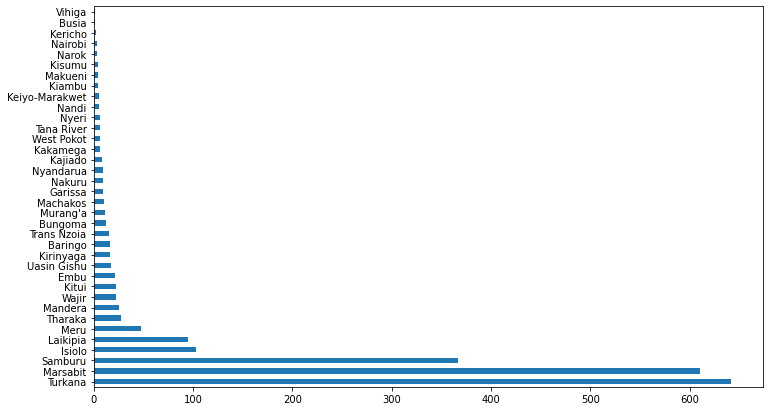

In [ ]:
#plotting the number of images per county...the number of sighted locust areas per county
locust_hub['COUNTY'].value_counts().plot(kind = 'barh',figsize=(12,7))


*The top three counties with the highest number of recorded attacks are Turkana, Marsabit and Samburu.*

**Loading the Kenyan Counties GeoBoundaries**

In [12]:
#loading the file with the Kenyan Adminstration boundaries
file_path = '/content/drive/My Drive/Omdena Project/Data/geoboundary.geojson'
#reading the json file using geopandas
geoboundary = gpd.read_file(file_path)
geoboundary.head()

,shapeName,shapeISO,shapeID,shapeGroup,shapeType,geometry
0,Bomet,KE-02,KEN-ADM1-3_0_0-B1,KEN,ADM1,"MULTIPOLYGON (((35.58631 -0.58674, 35.58790 -0..."
1,Kisii,KE-16,KEN-ADM1-3_0_0-B2,KEN,ADM1,"MULTIPOLYGON (((35.00129 -0.89357, 34.98792 -0..."
2,Narok,KE-33,KEN-ADM1-3_0_0-B3,KEN,ADM1,"MULTIPOLYGON (((36.34809 -1.17494, 36.33735 -1..."
3,Homa Bay,KE-08,KEN-ADM1-3_0_0-B4,KEN,ADM1,"MULTIPOLYGON (((35.02112 -0.41048, 35.02131 -0..."
4,Migori,KE-27,KEN-ADM1-3_0_0-B5,KEN,ADM1,"MULTIPOLYGON (((34.73151 -1.38936, 34.70255 -1..."


In [ ]:
#how many counties are in the dataset?
geoboundary.shapeName.nunique()

47

In [ ]:
geoboundary.shapeName.unique()

array(['Bomet', 'Kisii', 'Narok', 'Homa Bay', 'Migori', 'Nakuru',
       'Kajiado', 'Kericho', 'Kisumu', 'Nyamira', 'Siaya', 'Busia',
       'Vihiga', 'Machakos', 'Makueni', 'Nairobi', 'Baringo', 'Bungoma',
       'Elegeyo-Marakwet', 'Embu', 'Garissa', 'Isiolo', 'Kakamega',
       'Kiambu', 'Kilifi', 'Kirinyaga', 'Kitui', 'Kwale', 'Laikipia',
       'Lamu', 'Mandera', 'Marsabit', 'Meru', 'Mombasa', 'Nandi',
       'Nyandarua', 'Nyeri', 'Samburu', 'Taita Taveta', 'Tana River',
       'Tharaka-Nithi', 'Trans Nzoia', 'Turkana', 'Uasin Gishu', 'Wajir',
       'West Pokot', 'Murang`a'], dtype=object)

In [13]:
#saving the county names into a list
counties = geoboundary.shapeName.unique().tolist()

# saving the ploygons into a list too
polygons = geoboundary.geometry.tolist()

#combining the two list into a dictinary
county_poly = dict(zip(counties,polygons))

In [ ]:
#testing it out to identify a point in Mandera, from the Locust Hub dataset
P1 = Point(40.91667, 2.80000)
for county,poly in county_poly.items():
  #print(county)
  if P1.within(poly):
    print(county)

Mandera


*The logic seems to work perfectly, the next step is to classify the images accroding to their respective counties.*

In [ ]:
# testing it out with the rasters
image.bounds

BoundingBox(left=36.42012706947252, bottom=1.0200370051177166, right=36.440249331836796, top=1.040159267481994)

In [ ]:
#getting the centre coordinate
X = image.bounds[0] + (image.bounds[2] - image.bounds[0])

Y = image.bounds[1] + (image.bounds[3] - image.bounds[1])

In [ ]:
X,Y

(36.440249331836796, 1.040159267481994)

In [ ]:
P2 = Point(X,Y)
for county,poly in county_poly.items():
  #print(county)
  if P2.within(poly):
    print(county)

Turkana


*The logic also performs well on the rasters, the next stage is to go ahead and classify the rest of the images.*

In [14]:
#Creating a dataframe for storing the ndvi values
location_df = pd.DataFrame(columns = ["Image_ID","County"])

#iterating through all the images in the folder
for key in folder:
  #loading image from tif file using rasterio
  bf = rio.open(folder[key][0])

  #getting the centre coordinate
  X = bf.bounds[0] + (bf.bounds[2] - bf.bounds[0]) # X Coordinate
  Y = bf.bounds[1] + (bf.bounds[3] - bf.bounds[1]) # Y Coordinate

  #the coordinates for the centre of the Area of Interest
  P = Point(X,Y)
  for county,poly in county_poly.items():
    #print(county)
    if P.within(poly):
      #Saving the maximum NDVI difference 
      location_df = location_df.append({'Image_ID':key,'County':county},ignore_index = True)

    else:
      pass
      #print('dnfj')
  

In [15]:
location_df.head()

,Image_ID,County
0,1,Turkana
1,55,Turkana
2,53,Turkana
3,52,Turkana
4,51,Turkana


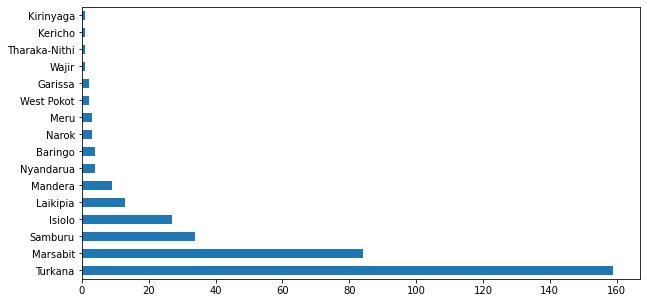

In [16]:
#checking the distribution of the images across the counties
location_df.County.value_counts().plot(kind = 'barh',figsize = (10,5))

In [17]:
#merging the two data frames for NDVI difference and location
location_NDVI_df = pd.merge(location_df,ndvi_diff_df,on = 'Image_ID')
location_NDVI_df.head()

,Image_ID,County,bf_ndvi,af_ndvi,diff_ndvi,ndvi_diff_max
0,1,Turkana,"[[0.6540928, 0.7247365, 0.73649657, 0.68076646...","[[0.67011, 0.66323024, 0.5968, 0.5591907, 0.58...","[[-0.016017199, 0.06150627, 0.13969654, 0.1215...",0.613031
1,55,Turkana,"[[0.08205321, 0.117272384, 0.1314328, 0.122627...","[[0.07734909, 0.09608798, 0.1018936, 0.0982822...","[[0.004704118, 0.021184407, 0.029539205, 0.024...",0.497875
2,53,Turkana,"[[0.14920926, 0.13477975, 0.11140065, 0.119540...","[[0.14750317, 0.12361743, 0.11880144, 0.138575...","[[0.0017060935, 0.011162318, -0.0074007884, -0...",0.235844
3,52,Turkana,"[[0.13408345, 0.18135959, 0.12106768, 0.122937...","[[0.15126427, 0.14806329, 0.1387508, 0.1270837...","[[-0.017180815, 0.033296302, -0.017683126, -0....",0.181141
4,51,Turkana,"[[0.06656226, 0.07846343, 0.08486622, 0.070197...","[[0.053564318, 0.057248764, 0.055595227, 0.052...","[[0.01299794, 0.021214664, 0.029270992, 0.0179...",0.236209


In [ ]:
location_NDVI_df.shape[0]

348

### Damage Assessment_Using NDVI Difference

In [ ]:
#assessing the damage from the first image
#comparing the NDVI for the first image
bf = rio.open(folder['1'][0])
af = rio.open(folder['1'][1])

# reading the NDVI band from the image
bf_ndvi = bf.read(17)
af_ndvi = af.read(17)

#calculating the NDVI difference
diff_ndvi = bf_ndvi - af_ndvi

Text(0.5, 1.0, 'NDVI Before')

Text(0.5, 1.0, 'NDVI After')

Text(0.5, 1.0, 'NDVI Difference')

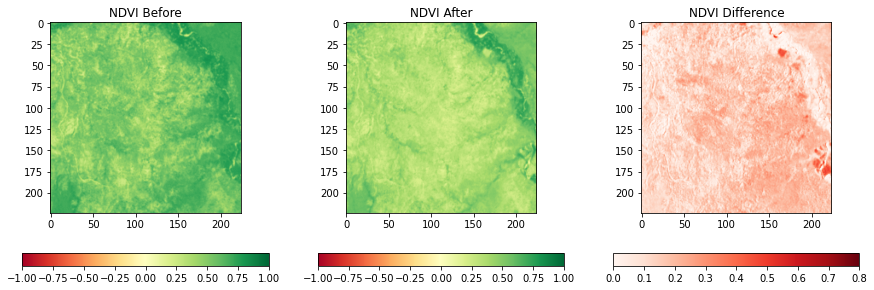

In [ ]:
#visualizing the difference
colormap = plt.cm.RdYlGn
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1, 3, 1)
imgplot = plt.imshow(bf_ndvi, cmap=colormap)
imgplot.set_clim(-1.0, 1.0)
ax.set_title('NDVI Before')
plt.colorbar(orientation='horizontal')

ax = fig.add_subplot(1, 3, 2)
imgplot = plt.imshow(af_ndvi, cmap=colormap)
imgplot.set_clim(-1.0, 1.0)
ax.set_title('NDVI After')
plt.colorbar(orientation='horizontal')

ax = fig.add_subplot(1, 3, 3)
imgplot = plt.imshow(diff_ndvi, cmap=plt.cm.Reds)
imgplot.set_clim(0.0, 0.8) # 0.8 because the vegetation starts at NDVI = 0.2 -> max. damage is 0.8
ax.set_title('NDVI Difference')
plt.colorbar(orientation='horizontal')

*The above plot clearly shows the change in NDVI. We can visualize the pixel distribution for the image next*

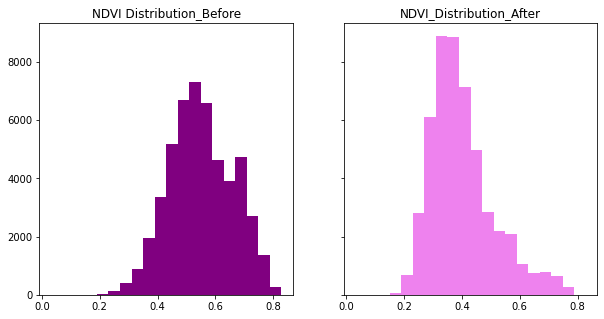

In [ ]:
#Creating an array that holds both the before and after NDVI values
Comb_ndvi = np.array([bf_ndvi,af_ndvi])
#Visualization using EarthPy
fig = ep.hist(
    Comb_ndvi,
    cols = 2,
    colors = ['Purple','Violet'],
    title = ['NDVI Distribution_Before','NDVI_Distribution_After'],
    figsize = (10,5)
)
plt.show()

***The next step would be to quantify the damage in hectares. We can do this by calculating the number of pixels where there was a reduction in NDVI in the after image compared to the before image. These are areas where the pixel in the ndvi_diff will have a value greater than 0.*** 

In [ ]:
# getting the number of pi
affected_pixels = 0
no_change = 0
more_vegetation = 0
for i in range(diff_ndvi.shape[0]):
    for j in range(diff_ndvi.shape[0]):
        if diff_ndvi[i][j] > 0.01:
            affected_pixels += 1
        elif diff_ndvi[i][j] < 0.01 and diff_ndvi[i][j] >-0.01:
            no_change +=1
        else:
            more_vegetation +=1

In [ ]:
affected_pixels

48975

In [ ]:
more_vegetation

609

In [ ]:
affected_area = (affected_pixels * 100)/10000
affected_area

489.75

In [19]:
#defining a function for calculating the damaged area
def damage_calculator(diff_ndvi):
  # getting the number of pi
  affected_pixels = 0
  no_change = 0
  more_vegetation = 0
  for i in range(diff_ndvi.shape[0]):
      for j in range(diff_ndvi.shape[0]):
          if diff_ndvi[i][j] > 0.01:
              affected_pixels += 1
          elif diff_ndvi[i][j] < 0.01 and diff_ndvi[i][j] >-0.01:
              no_change +=1
          else:
              more_vegetation +=1

  return (affected_pixels * 100)/10000


In [ ]:
#getting the damage(hectares for all the images)
location_NDVI_df['Damage(Hectares)'] = location_NDVI_df['diff_ndvi'].apply(damage_calculator)

In [21]:
location_NDVI_df.head()

,Image_ID,County,bf_ndvi,af_ndvi,diff_ndvi,ndvi_diff_max,Damage(Hectares)
0,1,Turkana,"[[0.6540928, 0.7247365, 0.73649657, 0.68076646...","[[0.67011, 0.66323024, 0.5968, 0.5591907, 0.58...","[[-0.016017199, 0.06150627, 0.13969654, 0.1215...",0.613031,489.75
1,55,Turkana,"[[0.08205321, 0.117272384, 0.1314328, 0.122627...","[[0.07734909, 0.09608798, 0.1018936, 0.0982822...","[[0.004704118, 0.021184407, 0.029539205, 0.024...",0.497875,298.03
2,53,Turkana,"[[0.14920926, 0.13477975, 0.11140065, 0.119540...","[[0.14750317, 0.12361743, 0.11880144, 0.138575...","[[0.0017060935, 0.011162318, -0.0074007884, -0...",0.235844,217.79
3,52,Turkana,"[[0.13408345, 0.18135959, 0.12106768, 0.122937...","[[0.15126427, 0.14806329, 0.1387508, 0.1270837...","[[-0.017180815, 0.033296302, -0.017683126, -0....",0.181141,312.28
4,51,Turkana,"[[0.06656226, 0.07846343, 0.08486622, 0.070197...","[[0.053564318, 0.057248764, 0.055595227, 0.052...","[[0.01299794, 0.021214664, 0.029270992, 0.0179...",0.236209,220.33


In [23]:
#grouping the images by county and adding all the damage areas
damage_df = pd.DataFrame(location_NDVI_df.groupby('County')['Damage(Hectares)'].sum())
damage_df.head()

,Damage(Hectares)
County,
Baringo,1123.38
Garissa,154.23
Isiolo,6183.95
Kericho,153.01
Kirinyaga,358.10


Text(0.5, 1.0, 'Total Area(Hectares) where vegetation(NDVI) reduction was observed ')

Text(0.5, 0, ' Area in Hectares')

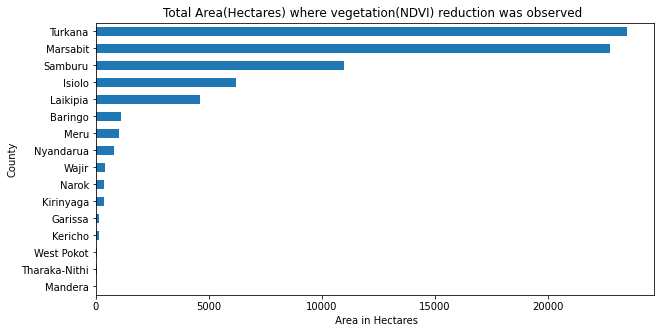

In [24]:
damage_df = damage_df.sort_values('Damage(Hectares)', ascending = True)
damage_df['Damage(Hectares)'].plot(kind = 'barh',figsize = (10,5))
plt.title('Total Area(Hectares) where vegetation(NDVI) reduction was observed ')
plt.xlabel(' Area in Hectares')
#plt.savefig('/content/drive/My Drive/Omdena Project/Data/NDVI_location_image.png', dpi=200, bbox_inches='tight', pad_inches=0.7)
plt.show()

This method only identifies the area affected but not the degree of damage in the area. The next steps would be:
1. Compare the results when using other vegatation indexes such as EVI or SAVI.
2. Use more advance approach to identify the degree of damage.

**Assessing the Degree of Damage**

The idea is to use the NDVI difference to categorize the pixels by the degree of damage. The following approach has been used:
- low damage - NDVI 0.01 to 0.2
- Moderate damage - NDVI > 0.2 to < 0.5
- High damage - NDVI > 0.5

In [25]:
#getting the low damage
def low_damage_calc(diff_ndvi):
  low = 0
  for i in range(diff_ndvi.shape[0]):
      for j in range(diff_ndvi.shape[0]):
          if diff_ndvi[i][j] >= 0.01 and diff_ndvi[i][j] <0.2 :
              low += 1

  return (low * 100)/10000


In [26]:
#getting the damage(hectares for all the images)
location_NDVI_df['low_damage(Hectares)'] = location_NDVI_df['diff_ndvi'].apply(low_damage_calc)

In [28]:
#getting the moderate damage
def moderate_damage_calc(diff_ndvi):
  moderate = 0
  for i in range(diff_ndvi.shape[0]):
      for j in range(diff_ndvi.shape[0]):
        #NDVI difference between 0.2 to 0.5
        if diff_ndvi[i][j] >= 0.2 and diff_ndvi[i][j] <0.5 :
              moderate += 1

  return (moderate * 100)/10000

#getting the high damage
def high_damage_calc(diff_ndvi):
  high = 0
  for i in range(diff_ndvi.shape[0]):
    for j in range(diff_ndvi.shape[0]):
        if diff_ndvi[i][j] >= 0.5:
            high += 1

  return (high* 100)/10000

In [29]:
#getting the moderate damage(hectares for all the images)
location_NDVI_df['moderate_damage(Hectares)'] = location_NDVI_df['diff_ndvi'].apply(moderate_damage_calc)
#getting the high damage(hectares for all the images)
location_NDVI_df['high_damage(Hectares)'] = location_NDVI_df['diff_ndvi'].apply(high_damage_calc)

In [30]:
location_NDVI_df.head()

,Image_ID,County,bf_ndvi,af_ndvi,diff_ndvi,ndvi_diff_max,Damage(Hectares),low_damage(Hectares),moderate_damage(Hectares),high_damage(Hectares)
0,1,Turkana,"[[0.6540928, 0.7247365, 0.73649657, 0.68076646...","[[0.67011, 0.66323024, 0.5968, 0.5591907, 0.58...","[[-0.016017199, 0.06150627, 0.13969654, 0.1215...",0.613031,489.75,374.81,114.86,0.08
1,55,Turkana,"[[0.08205321, 0.117272384, 0.1314328, 0.122627...","[[0.07734909, 0.09608798, 0.1018936, 0.0982822...","[[0.004704118, 0.021184407, 0.029539205, 0.024...",0.497875,298.03,296.40,1.63,0.00
2,53,Turkana,"[[0.14920926, 0.13477975, 0.11140065, 0.119540...","[[0.14750317, 0.12361743, 0.11880144, 0.138575...","[[0.0017060935, 0.011162318, -0.0074007884, -0...",0.235844,217.79,217.78,0.01,0.00
3,52,Turkana,"[[0.13408345, 0.18135959, 0.12106768, 0.122937...","[[0.15126427, 0.14806329, 0.1387508, 0.1270837...","[[-0.017180815, 0.033296302, -0.017683126, -0....",0.181141,312.28,312.28,0.00,0.00
4,51,Turkana,"[[0.06656226, 0.07846343, 0.08486622, 0.070197...","[[0.053564318, 0.057248764, 0.055595227, 0.052...","[[0.01299794, 0.021214664, 0.029270992, 0.0179...",0.236209,220.33,220.22,0.11,0.00


In [31]:
#grouping the images by county and adding all the damage areas
damage_df = pd.DataFrame(location_NDVI_df.groupby('County')[['Damage(Hectares)','low_damage(Hectares)','moderate_damage(Hectares)','high_damage(Hectares)']].sum())
damage_df.head()

,Damage(Hectares),low_damage(Hectares),moderate_damage(Hectares),high_damage(Hectares)
County,,,,
Baringo,1123.38,1062.41,60.92,0.05
Garissa,154.23,151.31,2.92,0.00
Isiolo,6183.95,6107.72,76.19,0.04
Kericho,153.01,117.32,35.69,0.00
Kirinyaga,358.10,235.76,89.72,32.62


In [ ]:
damage_df = damage_df.sort_values('Damage(Hectares)', ascending = True)
damage_df

,Damage(Hectares)
County,
Mandera,22.78
Tharaka-Nithi,70.32
West Pokot,73.96
Kericho,153.01
Garissa,154.23
Kirinyaga,358.10
Narok,369.57
Wajir,396.61
Nyandarua,797.06


Text(0.5, 1.0, 'Total Area(Hectares) where Low vegetation(NDVI) reduction was observed ')

Text(0.5, 0, ' Area in Hectares')

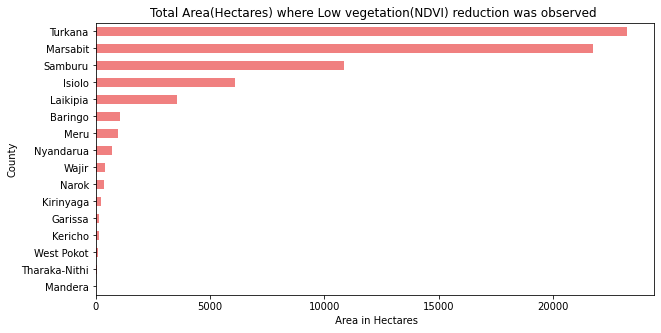

In [32]:
damage_df = damage_df.sort_values('low_damage(Hectares)', ascending = True)
damage_df['low_damage(Hectares)'].plot(kind = 'barh',figsize = (10,5),color ='lightcoral')
plt.title('Total Area(Hectares) where Low vegetation(NDVI) reduction was observed ')
plt.xlabel(' Area in Hectares')
#plt.savefig('/content/drive/My Drive/Omdena Project/Data/NDVI_location_image.png', dpi=200, bbox_inches='tight', pad_inches=0.7)
plt.show()

Text(0.5, 1.0, 'Total Area(Hectares) where Moderate vegetation(NDVI) reduction was observed ')

Text(0.5, 0, ' Area in Hectares')

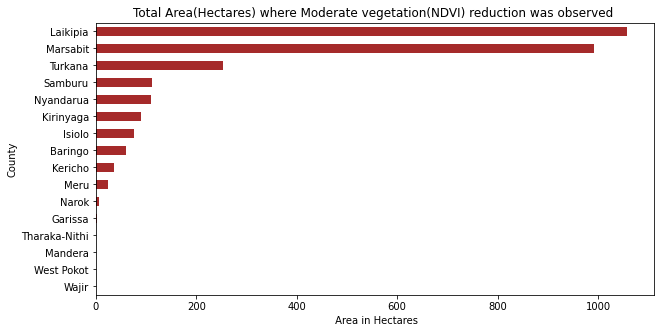

In [33]:
damage_df = damage_df.sort_values('moderate_damage(Hectares)', ascending = True)
damage_df['moderate_damage(Hectares)'].plot(kind = 'barh',figsize = (10,5),color ='brown')
plt.title('Total Area(Hectares) where Moderate vegetation(NDVI) reduction was observed ')
plt.xlabel(' Area in Hectares')
#plt.savefig('/content/drive/My Drive/Omdena Project/Data/NDVI_location_image.png', dpi=200, bbox_inches='tight', pad_inches=0.7)
plt.show()

Text(0.5, 1.0, 'Total Area(Hectares) where High vegetation(NDVI) reduction was observed ')

Text(0.5, 0, ' Area in Hectares')

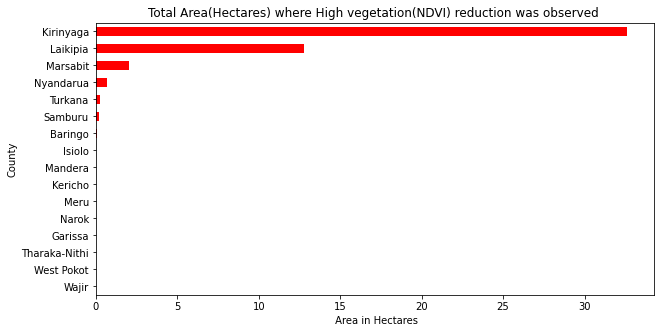

In [34]:
damage_df = damage_df.sort_values('high_damage(Hectares)', ascending = True)
damage_df['high_damage(Hectares)'].plot(kind = 'barh',figsize = (10,5),color ='red')
plt.title('Total Area(Hectares) where High vegetation(NDVI) reduction was observed ')
plt.xlabel(' Area in Hectares')
#plt.savefig('/content/drive/My Drive/Omdena Project/Data/NDVI_location_image.png', dpi=200, bbox_inches='tight', pad_inches=0.7)
plt.show()

In [36]:
 Total_Degree= [damage_df['low_damage(Hectares)'].sum(), damage_df['moderate_damage(Hectares)'].sum(), damage_df['high_damage(Hectares)'].sum()]
 Total_Degree

[69697.83000000002, 2821.0499999999997, 48.599999999999994]

In [38]:
sum(Total_Degree)

72567.48000000003

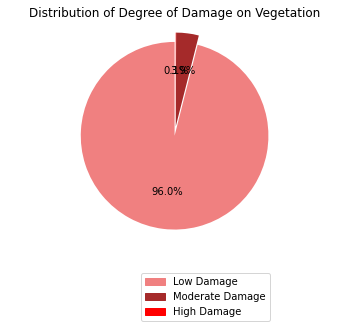

In [40]:
#color map for the degree of damage
labels = {0:'Low Damage', 1:'Moderate Damage', 2:'High Damage'}
colors = {0:'lightcoral', 1:'brown',2:'red'}
patches = [ mpatches.Patch(color=colors[i], label=f'{labels[i]}') for i in range(len(labels)) ]

#labels
labels = ['Low Damage','Moderate Damage','High Damage']

explode = (0.1, 0, 0)  # only "explode" the 2nd slice 
#plotting the piechart
fig1, ax1 = plt.subplots()
ax1.pie(Total_Degree, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=False,labeldistance = None,colors= ['lightcoral','brown','red'], startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Distribution of Degree of Damage on Vegetation')

plt.legend(handles=patches, bbox_to_anchor=(0.4, -0.15), loc=2, borderaxespad=0. )

#plt.savefig('/content/drive/My Drive/Omdena Project/Visualizations_Damage_Assessment/degree_damage_pie_chart.png', dpi=200, bbox_inches='tight', pad_inches=0.7)
plt.show();

Assumptions/Caveats
1. All pixels where a negative change in NDVI between the after and before image was considered regardless of it's landcover type.

**Results:**

1. The total area of land with a reduction of NDVI observed after the Locust attacks was 72,567.48 Ha
2. From the graphs, in all the vegetation types, most of the damage was of a lower degree(An NDVI difference of less than 0.2.) with 96%.
3. The most affected counties in terms of total area affected were:
    1. Turkana	23,497.84 Ha
    2. Marsabit	22,743.13 Ha
    3. Samburu	10,982.49 Ha



